In [1]:
import sparse
import subprocess
import shlex
import pandas as pd
import numpy as np

import glob
import os
import wget
import requests
import glob
import time
import dask
import h5py

from Bio import SeqIO
import pickle
import sys
sys.setrecursionlimit( 10 **9 )
from sklearn.cluster import *
from sklearn.metrics import roc_curve , precision_recall_curve , auc

import scipy
import copy
from numpy import linalg as LA
from matplotlib import pyplot as plt
import random
import h5py
import itertools
import dendropy
import os
import psutil
import seaborn as sns


overwrite = False
jk_iterations = 5
os.environ['MKL_ENABLE_INSTRUCTIONS'] = 'AVX2'

In [2]:
filedir = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/'

files = glob.glob( '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/apr_4_2022/mmsa_2022-04-04/2022-04-04_masked.fa_02022-06-14T07:53:44.200443small_test_coevmats.pkl')
print(files)

['/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/apr_4_2022/mmsa_2022-04-04/2022-04-04_masked.fa_02022-06-14T07:53:44.200443small_test_coevmats.pkl']


In [3]:
#treefile = '../validation_data/covid19/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.aln.EPIID.treefile'
#alnfile = '../validation_data/covid19/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.aln'
alnfile = filedir + 'datasets/covid_data/msa_0730/msa_0730.fasta'

treefile = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/feb_2021/GISAID-hCoV-19-phylogeny-2021-02-21/global.tree'
modeldir = filedir+'datasets/covid_data/structs/'

alnh5 = alnfile+'.h5'
#ts = '2021-08-08T11:16:34.358764'
#ts = '2021-08-08T14:37:59.736512'
#events = alnfile+'*'+ts+'*'
eventmats = files

In [20]:
tree = dendropy.Tree.get( path=treefile, schema='newick' )

741326
nodes


/users/dmoi/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


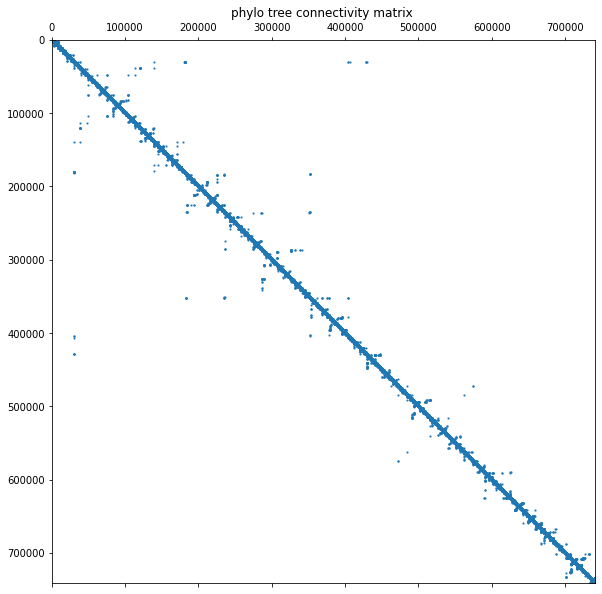

In [43]:
tns = dendropy.TaxonNamespace(label="taxa")
for i,n in enumerate(tree.nodes()):
    n.matrow = i
    n.taxon = i
    n.symbols = None
    n.scores = None
    n.event = None
    n.char = None
    tns.add_taxon(i)
tree.taxon_namespace = tns
matsize = len(tree.nodes())
print(matsize)
print('nodes')
connectmat = scipy.sparse.csc_matrix((len(tree.nodes()), len(tree.nodes() ) ) )
index = np.array([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])
lengths = np.array([ c.edge_length for n in tree.nodes() for c in n.child_nodes()])
total_len = np.sum(lengths)
#fill diagonal
#index = np.vstack( [index , np.array([ [n.matrow, n.matrow ] for n in tree.nodes() ]) ] )

connectmat[index[:,0],index[:,1]] = lengths
connectmat[index[:,1],index[:,0]] = lengths


#connectmat = connectmat.todense()
diag = [ i for i in range(connectmat.shape[0])]
connectmat[diag,diag] = 1

#connectmat = connectmat.todense()
#connectmat = scipy.sparse.csc_matrix(connectmat)
#np.fill_diagonal(connectmat , 1)

plt.figure( figsize=(10,10))
plt.title( 'phylo tree connectivity matrix ' )
plt.spy(scipy.sparse.coo_matrix(connectmat), markersize= 1)
plt.show()

In [44]:
nucleotide_mutation = None
AA_mutation = None
for mat in eventmats:
    with open( mat , 'rb') as pklin:
        mats = pickle.loads(pklin.read())
        print(mats)
        if AA_mutation is None:
            nucleotide_mutation = mats[1]
            AA_mutation = mats[0]
        else:
            nucleotide_mutation += mats[1]
            AA_mutation += mats[0]
print(nucleotide_mutation)
print(AA_mutation)

(<COO: shape=(741326, 29891, 380), dtype=float64, nnz=93228, fill_value=0.0>, <COO: shape=(741326, 29891, 12), dtype=float64, nnz=156073, fill_value=0.0>)
<COO: shape=(741326, 29891, 12), dtype=float64, nnz=156073, fill_value=0.0>
<COO: shape=(741326, 29891, 380), dtype=float64, nnz=93228, fill_value=0.0>


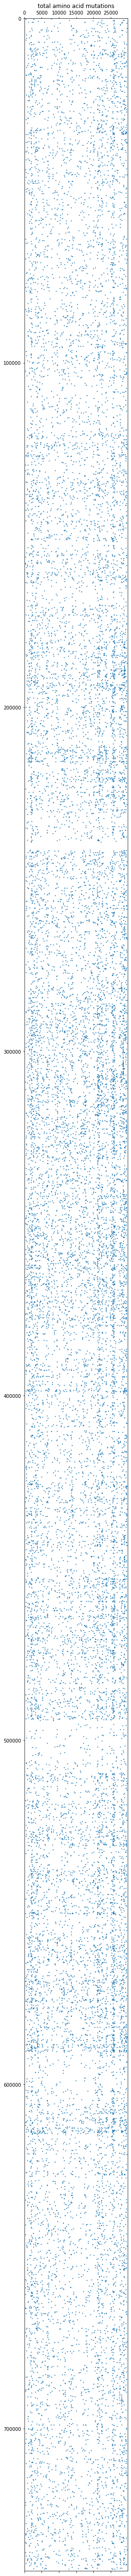

In [45]:
AAmat = AA_mutation.sum(axis = 2).to_scipy_sparse()
plt.figure(figsize=(10,100))
plt.spy(AAmat, markersize= .5)
plt.title('total amino acid mutations')
plt.show()

In [46]:
c1 = 10000
c2 = 10024
col1 = AA_mutation[:,c1,:] 
col2 = AA_mutation[:,c2,:] 

print(col1,col2, col1.coords, col2.coords)

both = col1+col2
both = both.sum(axis=1)
nodefilter = list(set(both.coords[0]))

<COO: shape=(741326, 380), dtype=float64, nnz=4, fill_value=0.0> <COO: shape=(741326, 380), dtype=float64, nnz=4, fill_value=0.0> [[338590 374211 405751 456352]
 [   289    289    289    289]] [[145102 488220 608705 696350]
 [   256    256    253    256]]


In [47]:
filter_fn  = lambda x : x.matrow in nodefilter
nodes = tree.find_nodes(filter_fn=filter_fn)
print(nodes)

[<Node object at 0x7f4b1e5995e0: '0.950' (145102)>, <Node object at 0x7f4ab0ab4550: '0.860' (338590)>, <Node object at 0x7f4aae789490: '0.890' (374211)>, <Node object at 0x7f4aac845070: '0.810' (405751)>, <Node object at 0x7f4aa95fa7f0: '0.960' (456352)>, <Node object at 0x7f4aa768bfd0: '0.940' (488220)>, <Node object at 0x7f4a9fc2a5b0: '0.950' (608705)>, <Node object at 0x7f4a99df1790: '0.860' (696350)>]


In [48]:
n1 = nodes[0].taxon
n2 = nodes[1].taxon

In [53]:
import networkx as nx
#load graph
cmat= scipy.sparse.coo_matrix(connectmat)
G = nx.from_edgelist(list(zip(list(cmat.col), list(cmat.row))))
for e in G.edges():
    G[e[0]][e[1]]['weight'] = connectmat[e[0],e[1]]

Graph with 406 nodes and 811 edges


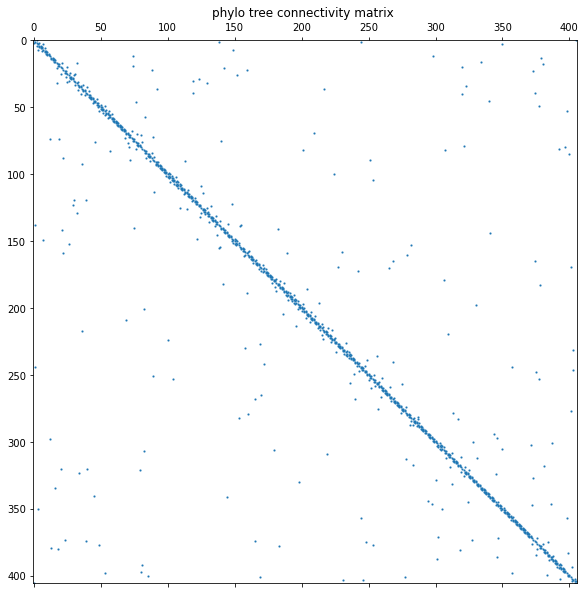

In [35]:
paths = [ nx.shortest_path(G, source=n1, target=n2, weight=None, method='dijkstra') for i,n1 in enumerate(nodefilter)
 for j,n2 in enumerate( nodefilter ) if i< j]
allnodes = set([])
for p in paths:
    allnodes = allnodes.union(p)
#find the clipped subtrees
#add a type of node to summarize clipped subtree
allnodes = list(allnodes)
connectmat = sparse.COO(connectmat)
submat = connectmat[allnodes,:]
submat = submat[:, allnodes]
submat = submat.to_scipy_sparse()
subG = nx.from_edgelist(list(zip(list(submat.col), list(submat.row))))
print(subG)
plt.figure( figsize=(10,10))
plt.title( 'phylo tree connectivity matrix ' )
plt.spy(submat , markersize= 1)
plt.show()
#select subgraph
#collapse nodes we degree 2